# TicTacToe using SARSA - part 2 - Function Approximation with a NN

In the previous part I made an agent who could be me in TicTacToe using an algorithm called SARSA, and keeping all the exact states that it ever encountered (~4.5k). Let's see if we can improve this now, using a function approximation of the total states.

I will be using the (semi-gradient 1-step) SARSA with function approximation. You can learn more about it in [Sutton & Barto's book (2nd edition)](https://d3c33hcgiwev3.cloudfront.net/Ph9QFZnEEemRfw7JJ0OZYA_808e8e7d9a544e1eb31ad11069d45dc4_RLbook2018.pdf?Expires=1578700800&Signature=kknv~Fe2hgmHae7aID4u9P9BUwvcIQ2F5qaNopIiaOpjUeiqESW6W4xhnji1Yyf1dEgNg5NvaKCqAOtHPX65N4LFHM3cU-Zj3WQFRl1S~NM79uQSWijIvnCNAIvPVSLct6i5u7Ruc-IkWYDGoPFtyHUWq8iFH1WJBuOZTaw~QzQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A), in chapter 10.

In addition to the modules discussed in part 1, I will also be using a softmax function (if you don't know what it is, you can read about it here) and a "simple" Feed-Forward / Dense Neural Network - which is implemented in Keras. I set the default activations for the layers to be the sigmoid function (you can read about it in the same link as the softmax). I did play with a non-keras manual-numpy implementation of a NN, using ReLu's, but they didn't seem to work so great (but it could be there were some bugs in my implementation). In any case, ReLu makes more sense if you have a deep network, but the implementations here are more shallow, so a sigmoid will work just fine (oh, no - spoiler).

In [1]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue
from Softmax import softmax
from SimpleNN import SimpleKerasNN

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
%load_ext autoreload
%autoreload 2

No change for the environment.

In [127]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board.copy().reshape(9,), self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board.copy().reshape(9,), self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask
    
    def transform_index(self, index):
        return index // 3, index % 3

The agent now will have to calculate the Q(s,a) using it's function approximator, aka - the neural network. It will then use the softmax function to calculate the (adjusted by available options) probabilities of the actions for the given state, and choose an action using these probabilities.

(The dimensions must be handled a bit differently in order to be fed to the NN)

In [128]:
class TicTacToeAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.discount = agent_init_info["discount"]        
        self.network = agent_init_info["network"]
        self.tau = agent_init_info["tau"]
        self.num_actions = agent_init_info["num_actions"]
        
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        action_values = self.network.predict(state)
        probs = softmax(action_values, self.tau) 
        probs *= mask
        probs /= probs.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        self.last_state = state.reshape(1, -1)
        self.last_action = self.policy(self.last_state, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        state = state.reshape(1, -1)
        action = self.policy(state, mask)
        target = self.network.predict(self.last_state)[0]
        correct = reward + self.discount * self.network.predict(state)[0][action]
        target[self.last_action] = correct
        self.network.train(self.last_state, target.reshape(1,-1))
        
        self.last_state = state
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        target = self.network.predict(self.last_state)[0]
        target[self.last_action] = reward
        self.network.train(self.last_state, target.reshape(1, -1))
        
    def agent_message(self, message):
        pass

# Train

As a Proof of Concept - I first use a relatively big network. It has ~2k parameters. The exact solution had to keep ~4.5k states, and for each state to keep 9 action-values. So it's a big improvement over it, in terms of space and memory.  

![nn](nn36x36.svg)

In [81]:
# define the function approximator - a Feed-Forward NN 
layers1 = [9, 36, 36, 9]
layers2 = [9, 36, 36, 9]
nn1 = SimpleKerasNN(layers1, lr=0.1)
nn2 = SimpleKerasNN(layers2, lr=0.1)

I ran it 5 times for 10k episodes each. The improvement was slow, but noticeable. 

In [97]:
runs = 50000

In [98]:
def experiment(runs, nns):
    rlglue = RLGlue(TicTacToeEvnironment, TicTacToeAgent, TicTacToeAgent)
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    agent1_info = {"discount": 1, "network": nns[0], "tau": 1, "num_actions": 9, "seed": 747}
    agent2_info = {"discount": 1, "network": nns[1], "tau": 1, "num_actions": 9, "seed": 101}
    env_info = {}
    rlglue.rl_init(agent1_info, agent2_info, env_info)

    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [104]:
rlg, rew, starts, states = experiment(runs, [nn1, nn2])

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:24<00:00, 75.70it/s]


# Test

In [105]:
starts[-1], states[-1]

(array([-1.]), array([-1., -1., -1.,  1., -1.,  1.,  0.,  1.,  0.]))

Ok, not a lot of 0's - this is a good indication of an interesting game

In [106]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(3554, 3088)

only 6k/20k wins - the rest are ties! Good indication that both agents learn well

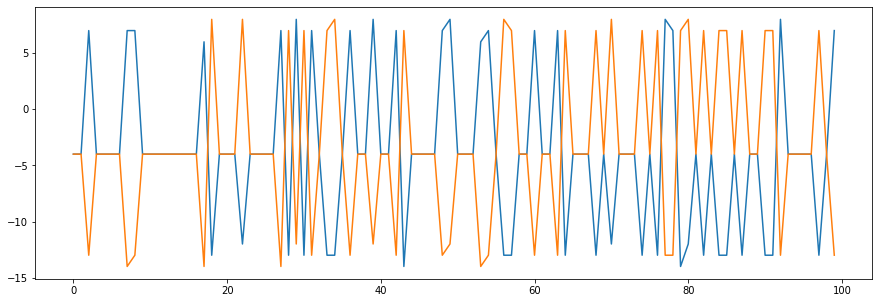

In [107]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

Let's play a game

In [108]:
env = TicTacToeEvnironment()
env.env_init()
ret = env.env_start()

In [113]:
ai = rlg.agents[-1]["agent"]

In [114]:
action = ai.agent_start(ret[0], ret[1])
action

6

In [115]:
ret = env.env_step(-1, action)

In [116]:
# Human (aka - me) will play 4, middle square
ret = env.env_step(1, 4)

In [117]:
action = ai.agent_step(-1, ret[1], ret[3])
action

2

In [118]:
ret = env.env_step(-1, action)

In [119]:
# I choose 0
ret = env.env_step(1, 0)

In [120]:
action = ai.agent_step(-1, ret[1], ret[3])
action

8

AI chooses 8 to block me - good move!

In [121]:
ret = env.env_step(-1, action)

In [123]:
# I'll try to block him at 5
ret = env.env_step(1, 5)

In [124]:
action = ai.agent_step(-1, ret[1], ret[3])
action

7

In [125]:
env.env_step(-1, action)

(10,
 array([[ 1.,  0., -1.,  0.,  1.,  1., -1., -1., -1.]]),
 True,
 array([0., 1., 0., 1., 0., 0., 0., 0., 0.]))

AI wins :-) 

In [126]:
# lets save this agent
ai.network.model.save_weights("agent-3-keras-9-36-36-9.h5")

# Face Off - Exact Agent vs. NN Agent

In [129]:
class TicTacToeExactAgent(BaseAgent):
    def agent_init(self, agent_init_info):    
        self.learning_step = agent_init_info["learning_step"]
        self.num_actions = agent_init_info["num_actions"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.states = {}
        self.last_state = None
        self.last_action = None

    def policy(self, q, mask):
        # greedy policy, breaks ties randomly
        pos = np.exp(q - np.max(q)) * mask
        return self.argmax(pos)

    def argmax(self, array):
        m = np.max(array)
        ind = np.where(array == m)[0]
        return self.rand_generator.choice(ind)
    
    def get_q(self, state, mask):
        if str(state) in self.states:
            q = self.states[str(state)]
        else:
            q = np.zeros_like(state)
            q[mask == 1] = 1
        return q
    
    def agent_start(self, state, mask):
        self.last_state = state
        q = self.get_q(state, mask)
        self.states[str(self.last_state)] = q
        self.last_action = self.policy(q, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        q = self.get_q(state, mask)
        action = self.policy(q, mask)
        q_s_ = q[action]
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward + q_s_ - q_s)

        self.last_state = state
        self.states[str(self.last_state)] = q
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward - q_s)
        
    def agent_message(self, message):
        pass

In [130]:
rlglue = RLGlue(TicTacToeEvnironment, TicTacToeExactAgent, TicTacToeAgent)
agent1_info = {"learning_step": 1, "num_actions": 9, "seed": 12}
agent2_info = {"discount": 1, "network": nn2, "tau": 1, "num_actions": 9, "seed": 176}
env_info = {}
rlglue.rl_init(agent1_info, agent2_info, env_info)

In [131]:
# reload states into our exact agent
fr = open('agent-exact-states','rb')
rlglue.agents[-1]["agent"].states = pickle.load(fr)
fr.close()

In [140]:
runs = 10000  # 

In [141]:
def experiment(rlglue, runs):
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [142]:
rlg, rew, starts, states = experiment(rlglue, runs)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:59<00:00, 83.93it/s]


In [143]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(1721, 0)

We see that the exact agent won 1721 games out of 10k, the rest were tied. The NN never won a game. Still, tie-ing with the exact agent for 83% of the games is impressive.

# Conclusion

It took 50k games to reach a less optimal level than the exact model. This model used ~ 2k weights, while the exact solution had to keep ~ 4.5k states x9 action values per state. But it did take much more time to train. 

When facing the NN agent with an exact agent, it became clear that the Exact agent is much better. Though after some practice, the NN agent improve, and didn't lose as much.

Note: I thought perhaps that the slow learning also came because I used a small learning rate. But using a larger learning rate didn't help (and in some cases made the networks explode). Obviously the learning rate parameter is one of the most important parameters, and a lot depends on it. IMO, it is better to go slow and in the right direction, then fast and all over the place. 

In [146]:
rlg.agents[1]["agent"].network.model.save_weights("agent-5-nn-9x36x36x9.h5")